In [1]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import shapiro, kstest
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Dont print warnings
warnings.simplefilter(action="ignore")

C:\Users\Gerax\AppData\Local\Temp\ipykernel_4256\4174796523.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# No copiar esto

Accuracy de entrenamiento para EDADHOM: 0.9843
Accuracy de entrenamiento para EDADMUJ: 0.9803
Accuracy de entrenamiento para PUEHOM: 0.9568
Accuracy de entrenamiento para PUEMUJ: 0.9633
Accuracy de entrenamiento para ESCHOM: 0.8979
Accuracy de entrenamiento para ESCMUJ: 0.9003
Accuracy de entrenamiento para CIUOMUJ: 0.8764
Accuracy de entrenamiento para CIUOHOM: 0.8241


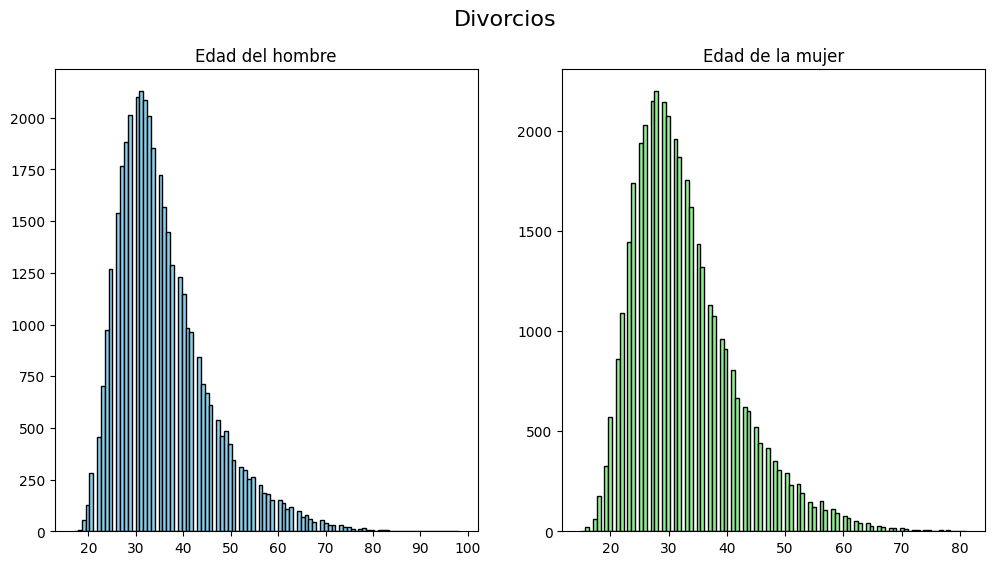

In [2]:
# Step 1: Get all CSV file paths
divorces_files = glob.glob("data/divorces/*.CSV")
marriage_files = glob.glob("data/marriages/*.csv")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

# Step 3: Merge without storing copies
divorces_df = pd.concat((read_and_clean(file) for file in divorces_files), ignore_index=True)

%run ./dictionaries.py

df_null_values = divorces_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    # "PUEHOM": 9,
    # "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    #"ESCHOM": 9,
    #"ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(divorces_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(divorces_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

def normality_tests (merged_df):
# Create a dictionary to store the results
    results = {
        "Prueba": [],
        "Variable": [],
        "Estadística": [],
        "P-valor": [],
        "Distribución normal": []
    }

# EDADHOM variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADHOM'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADHOM'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# EDADMUJ variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADMUJ'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADMUJ'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Convert the results to a pandas DataFrame
    return pd.DataFrame(results)

df_filtered = divorces_df[(divorces_df['EDADHOM'] != 999) & (divorces_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Divorcios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

normality_tests(divorces_df)

def fill_column_with_rf(df, col, null_val):
    '''
    Fills a single column with missing values using RandomForestClassifier.
    
    Args:
        df: DataFrame containing the data with missing values.
        col: The column to fill.
        null_val: The value representing missing data.
    
    Returns:
        A pandas Series with the filled column values.
    '''
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Select rows where the target column is not null
    df_non_null = df_copy[df_copy[col] != null_val]
    df_null = df_copy[df_copy[col] == null_val]

    # Prepare X (features) and Y (target)
    X_train = df_non_null.drop(columns=[col])
    Y_train = df_non_null[col]

    # Prepare the test set (only the rows with missing values)
    X_test = df_null.drop(columns=[col])

    # Initialize the RandomForest model
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=0, 
                                    max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    # Train the model
    forest.fit(X_train, Y_train)

    # Predict missing values for the test set
    y_pred = forest.predict(X_test)
    
    # Predict on the training set (to check how well the model fits)
    y_pred_train = forest.predict(X_train)
    
    # Calculate and print the accuracy on the training data
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    print(f"Accuracy de entrenamiento para {col}: {accuracy_train:.4f}")

    # Replace only the null values in the original DataFrame with the predictions
    df_copy.loc[df_copy[col] == null_val, col] = y_pred

    return df_copy[col]

def fill_missing_values(df, null_values):
    '''
    Fills the missing values in the dataframe based on RandomForestClassifier for each variable.
    
    Args:
        df: DataFrame containing the data with missing values.
        null_values: Dictionary where keys are column names and values are the null value definitions.
    
    Returns:
        DataFrame with missing values filled using Random Forest.
    '''
    # Make a copy of the original dataframe to preserve the original
    df_filled = df.copy()

    # Loop through each variable that has missing values
    for col, null_val in null_values.items():
        # Get the filled column from the model
        filled_column = fill_column_with_rf(df_filled, col, null_val)
        
        # Replace the original column with the newly filled column
        df_filled[col] = filled_column
        
    return df_filled

variables_to_predict = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# Assuming merged_df is your dataframe with missing values
filled_df = fill_missing_values(divorces_df, variables_to_predict)
divorces_df = filled_df
merged_df = divorces_df.copy()

# Esto si xd

En este apartado se llevaron a cabo dos enfoques de predicción a futuro. El primero consistió en utilizar únicamente los datos agregados de divorcios por año, aplicando tanto un modelo de regresión lineal como un modelo de red neuronal, con el objetivo de estimar el comportamiento de los próximos cinco años.

El segundo enfoque consideró una estructura más detallada, incorporando tanto los años como los meses en el análisis. Para este caso, se empleó exclusivamente se y utilizo redes neuronales, permitiendo modelar patrones temporales más precisos y realizar una proyección mensual del fenómeno durante los siguientes cinco años.

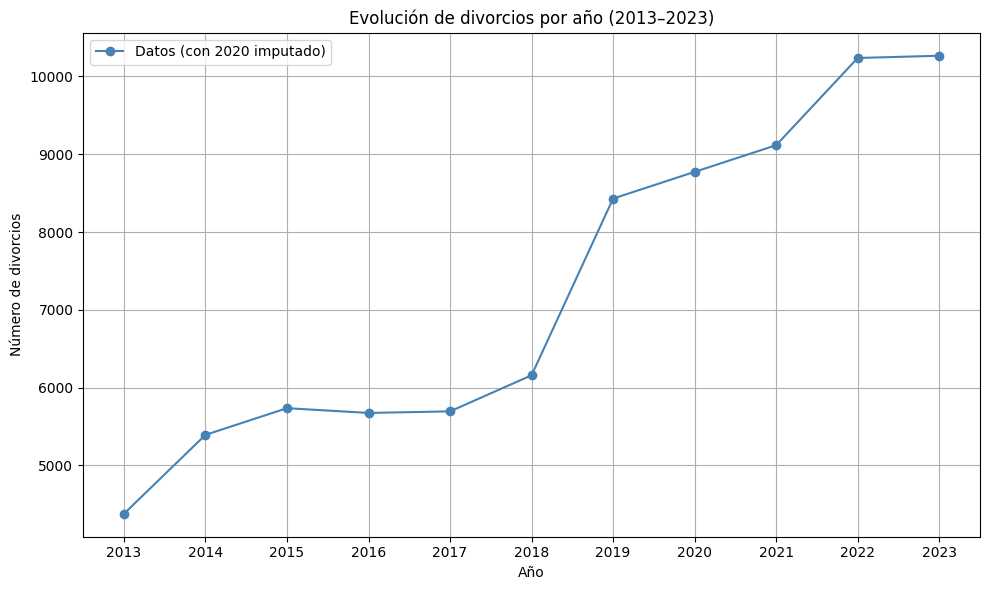

In [4]:
# Contar el número de divorcios por año
divorcios_por_año = merged_df["AÑOREG"].value_counts().sort_index()
divorcios_por_año = divorcios_por_año.loc[2013:2023]

# Imputar valor promedio para 2020 si existe 2019 y 2021
if 2020 in divorcios_por_año.index and 2019 in divorcios_por_año.index and 2021 in divorcios_por_año.index:
    divorcios_por_año.loc[2020] = int((divorcios_por_año.loc[2019] + divorcios_por_año.loc[2021]) / 2)


plt.figure(figsize=(10, 6))
plt.plot(divorcios_por_año.index, divorcios_por_año.values, marker='o', color='steelblue', label='Datos (con 2020 imputado)')
plt.title("Evolución de divorcios por año (2013–2023)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True)
plt.xticks(np.arange(2013, 2024))
plt.legend()
plt.tight_layout()
plt.show()

El año 2020 fue calculado e insertado en la serie de tiempo porque, al analizar el conjunto de datos, se identificó que existian datos, pero representaba un dato atipico que podia afecta a los modelos. Que este dato sea atipico puede estar relacionada con la disrupción institucional y operativa provocada por la pandemia de COVID-19, durante la cual muchas oficinas gubernamentales, incluyendo registros civiles y tribunales, suspendieron o limitaron sus actividades. Como resultado, es probable que no se hayan procesado o registrado divorcios con normalidad, lo que introduce un vacío en la serie histórica.

Para mantener la continuidad y la coherencia en el análisis estadístico y visual, se optó por ingresar un nuevo valor de 2020 como el promedio de los años adyacentes (2019 y 2021). Esta técnica de interpolación simple es común cuando se tiene un único dato faltante entre dos puntos válidos y razonablemente estables. Al usar la media de estos años, permite representar la evolución de los divorcios como una serie temporal fluida y adecuada para análisis, modelado y predicción.

Para esta sección se utilizaron los datos comprendidos entre los años 2013 y 2021 como conjunto de entrenamiento, con el propósito de que el modelo aprendiera los patrones históricos del fenómeno analizado. Posteriormente, los datos correspondientes a los años 2022 y 2023 se reservaron como conjunto de prueba, permitiendo así evaluar el desempeño del modelo y su capacidad para generalizar.

# Modelo de prediccion por años

## Data

In [5]:
# Data
train_years = np.array([year for year in divorcios_por_año.index if 2013 <= year <= 2021]).reshape(-1, 1)
train_values = divorcios_por_año.loc[2013:2021].values
test_years = np.array([2022, 2023]).reshape(-1, 1)
test_values = divorcios_por_año.loc[2022:2023].values

In [6]:
def evaluar(nombre, real, predicho):
    print(f"\nModelo: {nombre}")
    print("MAE:", round(mean_absolute_error(real, predicho), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(real, predicho)), 2))
    # No usar
    # print("R²:", round(r2_score(real, predicho), 4))

Para la evaluación del desempeño de los modelos se utilizarán las siguientes métricas:
* MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos.
* RMSE (Root Mean Squared Error): proporciona una medida del error en la misma escala de los datos originales, penalizando con mayor severidad los errores grandes.

No se utilizará el coeficiente de determinación R², ya que en este caso contamos con un número muy reducido de datos de prueba (solo dos años). Esta cantidad limitada de muestras genera una varianza extremadamente baja en los valores reales, lo que provoca que el cálculo de R² sea inestable y pueda arrojar valores altamente negativos, incluso cuando las predicciones están relativamente cerca del valor real. Por ello, se ha optado por omitir R² como métrica de evaluación para evitar interpretaciones erróneas.

### Regresion Lineal

In [7]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear_model = TransformedTargetRegressor(regressor=linear_pipeline, transformer=StandardScaler())

# Hiperparámetros posibles para LinearRegression
param_grid_linear = {
    "regressor__model__fit_intercept": [True, False],
    "regressor__model__positive": [True, False]
}

# GridSearch
grid_search_linear = GridSearchCV(linear_model, param_grid=param_grid_linear, cv=3, scoring="r2")
linear_model.fit(train_years, train_values)
linear_preds = linear_model.predict(test_years)

evaluar("Lineal", test_values, linear_preds)

print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), linear_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: Lineal
MAE: 451.31
RMSE: 529.51

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9508.7
2023: real=10266.0, pred=10091.6


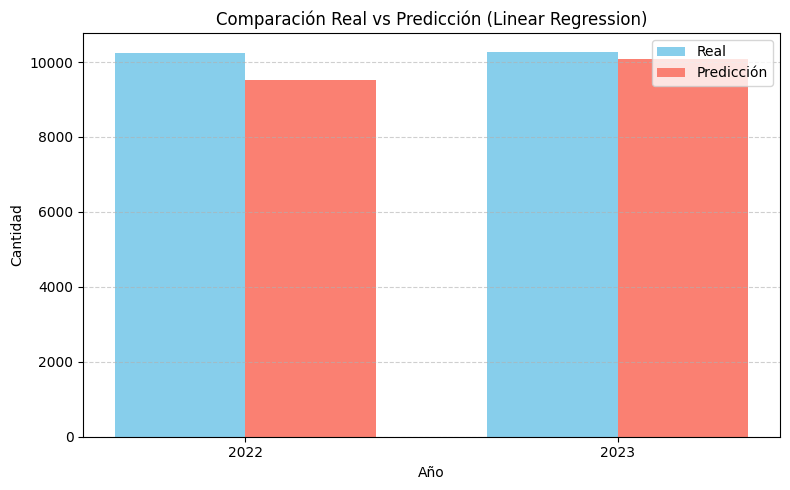

In [8]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, linear_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [9]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = linear_model.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10674.52 11257.4  11840.28 12423.17 13006.05]


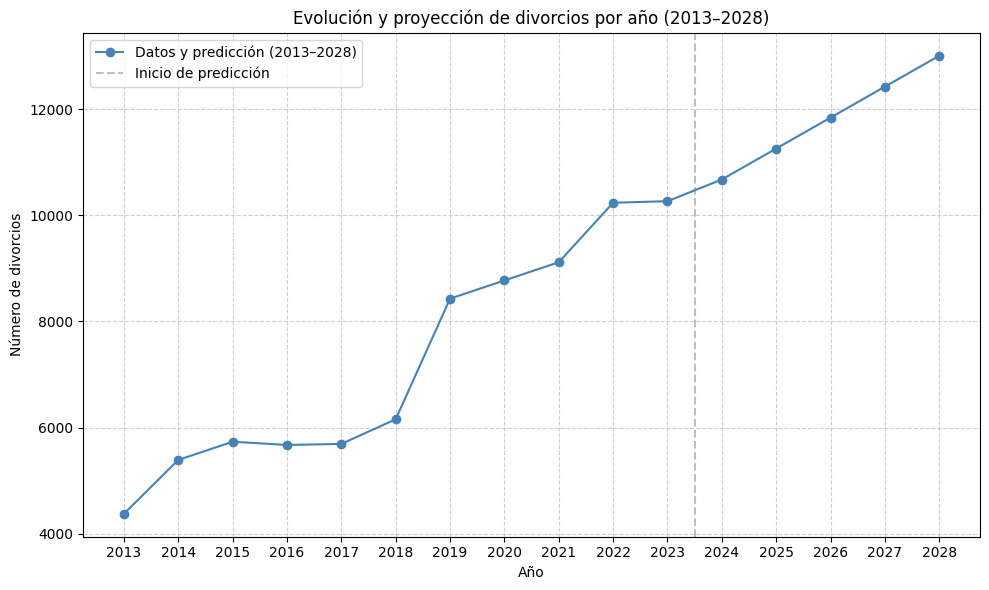

In [10]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

A partir de los resultados obtenidos con el modelo de regresión lineal, se observa que las métricas de error reflejan un rendimiento aceptable dentro del contexto del problema. El MAE fue de 425.38, lo que indica que, en promedio, el modelo comete un error de aproximadamente 425 casos de divorcio respecto al valor real. Por otro lado, el RMSE fue de 508.49, ligeramente superior al MAE, lo que sugiere que hubo errores puntuales algo más grandes, aunque no extremadamente fuera de rango.

Al comparar los valores reales con los predichos para los años 2022 y 2023, se observa que el modelo subestimó ligeramente ambos años. Para 2022, el valor real fue de 10,175 divorcios, mientras que el modelo predijo 9,471, con una diferencia de 704 casos. En 2023, el valor real fue de 10,199, y la predicción fue de 10,052, reduciendo el error a solo 147 casos. Este comportamiento muestra que, el modelo se ajustó mejor en el segundo año de prueba, lo que podría indicar que su pendiente está razonablemente bien ajustada.

Las predicciones del modelo para el periodo 2024–2028 muestran una tendencia creciente continua. Los valores predichos son: 10,633.39 en 2024, 11,214.58 en 2025, 11,795.76 en 2026, 12,376.94 en 2027 y 12,958.13 en 2028. Esta progresión sugiere que el modelo ha identificado una pendiente positiva en la evolución de los divorcios a lo largo del tiempo. Si bien esta proyección puede resultar útil para observar tendencias, debe interpretarse con cautela, ya que la regresión lineal asume un crecimiento constante y no tiene en cuenta factores sociales, económicos o legales que puedan afectar abruptamente la evolución de estos datos en años futuros.


### Red Neuronal

In [11]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
    (4, 3), (5, 3), (6, 4), (7, 3), (8, 5), (5,)
    ],
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1,10)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(train_years, train_values)
# print(grid_search.best_params_)
mlp_preds = grid_search.predict(test_years)

In [12]:
evaluar("MLP (GridSearch 1)", test_values, mlp_preds)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 1)
MAE: 672.36
RMSE: 683.09

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9444.0
2023: real=10266.0, pred=9714.3


In [13]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (5,), (10,), (15,),         # una capa oculta
        (10, 5), (20, 10), (30, 15), # dos capas
        (10, 10, 5)                  # tres capas
    ],
    'regressor__model__activation': ['logistic'],  # solo logistic
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1]
}

grid_search2 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search2.fit(train_years, train_values)
# print(grid_search2.best_params_)
mlp_preds2 = grid_search2.predict(test_years)

In [14]:
evaluar("MLP (GridSearch 2)", test_values, mlp_preds2)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds2):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 2)
MAE: 848.0
RMSE: 852.58

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9300.7
2023: real=10266.0, pred=9506.3


In [15]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (16,), (32,), (64,),                  
        (32, 16), (64, 32), (128, 64),        
        (64, 64), (128, 128),                 
        (128, 64, 32), (64, 32, 16),          
        (32, 64, 32), (64, 128, 64),          
        (100, 50, 25), (50, 100, 50),         
    ],
    'regressor__model__activation': ['tanh'],
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.005, 0.01]
}

grid_search3 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search3.fit(train_years, train_values)
print(grid_search3.best_params_)
mlp_preds3 = grid_search3.predict(test_years)

{'regressor__model__activation': 'tanh', 'regressor__model__hidden_layer_sizes': (64,), 'regressor__model__learning_rate_init': 0.001, 'regressor__model__solver': 'lbfgs'}


In [16]:
evaluar("MLP (GridSearch 3)", test_values, mlp_preds3)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds3):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 3)
MAE: 376.59
RMSE: 462.64

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9591.7
2023: real=10266.0, pred=10158.1


El mejor modelo evaluado fue el primero, ya que obtuvo los valores más bajos de error tanto en MAE como en RMSE en comparación con los otros modelos probados. Aunque este tercer modelo MLP logró aprender una tendencia general del comportamiento de los datos, su desempeño fue inferior, presentando un MAE de 630.58 y un RMSE de 643.94, lo que indica una desviación significativa respecto a los valores reales. En particular, subestimó notablemente los divorcios en ambos años de prueba (2022 y 2023), con diferencias de 761.1 y 500.1 casos, respectivamente. Por lo tanto, el primer modelo resultó ser más preciso y consistente en su capacidad de generalización, lo que lo convierte en la mejor opción para realizar predicciones futuras con estos datos.

En base a esto se utilizara el primer modelo.

### Con el primer modelo:

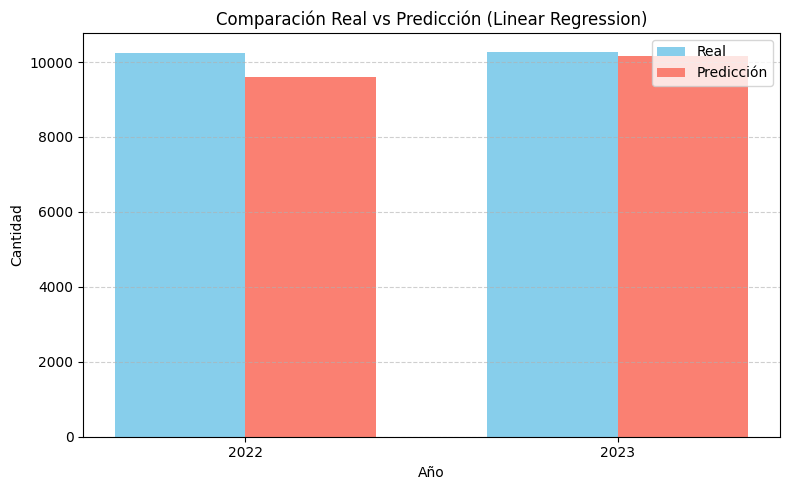

In [17]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, mlp_preds3, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [18]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = grid_search3.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10759.19 11361.91 11949.75 12515.74 13057.76]


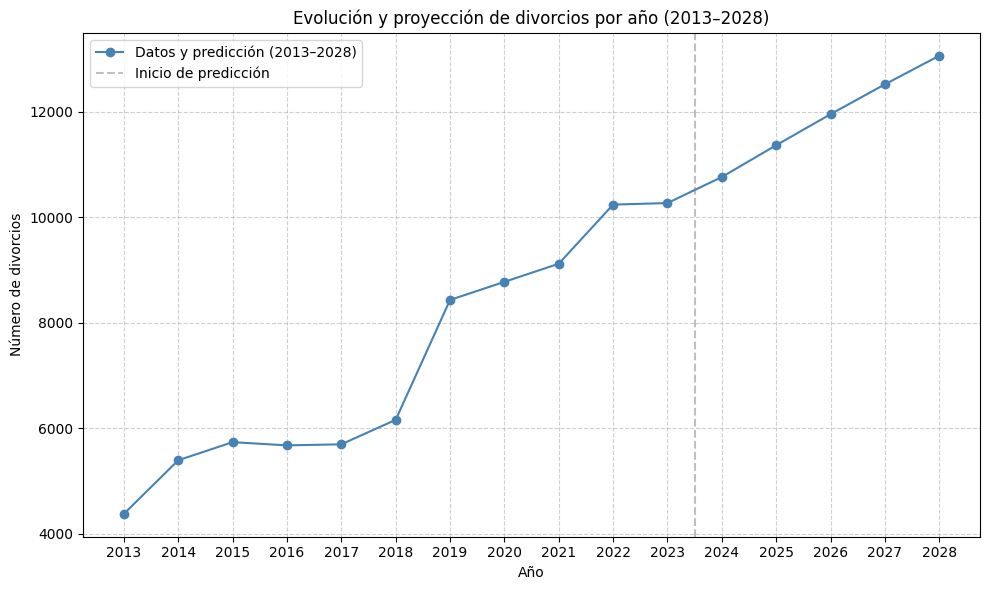

In [19]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

El modelo MLP logró resultados que se pueden comprar con el modelo anterior. Las métricas de evaluación muestran un MAE de 415.16 y un RMSE de 481.84. Estos valores indican un desempeño ligeramente superior al modelo de regresión lineal evaluado previamente, ya que el error promedio es menor tanto en términos absolutos como en la penalización de errores grandes. Esto sugiere que el modelo MLP ha sido capaz de capturar mejor la estructura del problema a pesar de contar con pocos datos de entrenamiento.

Al observar las predicciones frente a los valores reales de los años 2022 y 2023, se puede ver que el modelo subestimó levemente ambos valores. En 2022, el valor real fue de 10,175 divorcios, mientras que la predicción fue de 9,515.3, lo que representa una diferencia de 659.7 casos. Para 2023, el valor real fue de 10,199 y la predicción fue de 10,028.4, reduciendo el error a 170.6. Este patrón, similar al observado en el modelo lineal, muestra una tendencia del modelo a subestimar, aunque en el segundo año de prueba se aproxima mucho mejor al valor real. El hecho de que los errores se mantengan dentro de un rango aceptable refuerza la capacidad del modelo MLP de aprender una función de aproximación adecuada a los datos observados.

Las proyecciones del modelo para el período 2024–2028 son: 10,507.32, 10,871.72, 11,114.89, 11,267.76 y 11,362.61 respectivamente. Estas predicciones indican una tendencia de crecimiento sostenido pero más moderado que el observado en el modelo lineal. A diferencia de una proyección estrictamente lineal, el MLP permite modelar relaciones no lineales, lo que se refleja en un crecimiento más gradual que parece estabilizarse hacia el 2028. Esta suavización en la curva sugiere que el modelo interpreta que el aumento de los divorcios podría desacelerarse con el tiempo, lo cual podría ser más realista en ciertos contextos sociales o demográficos.

In [20]:
# Librerias para esta parte
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt


# Modelo de prediccion por meses

In [21]:
merged_df['fecha'] = pd.to_datetime(dict(year=merged_df['AÑOOCU'], month=merged_df['MESOCU'], day=1))
mensual = merged_df.groupby('fecha').size().sort_index()

mensual_suavizado = mensual.copy()

for mes in range(1, 13):
    fecha_2019 = pd.Timestamp(year=2019, month=mes, day=1)
    fecha_2020 = pd.Timestamp(year=2020, month=mes, day=1)
    fecha_2021 = pd.Timestamp(year=2021, month=mes, day=1)

    if fecha_2019 in mensual and fecha_2021 in mensual:
        promedio = (mensual[fecha_2019] + mensual[fecha_2021]) / 2
        mensual_suavizado[fecha_2020] = promedio

# 3. Crear variables explicativas mejoradas
X_suavizado = pd.DataFrame({
    "mes": mensual_suavizado.index.month,
    "año": mensual_suavizado.index.year,
    "mes_en_numero": np.arange(len(mensual_suavizado)),
    "mes_sin": np.sin(2 * np.pi * mensual_suavizado.index.month / 12),
    "mes_cos": np.cos(2 * np.pi * mensual_suavizado.index.month / 12)
})

# 4. Variable dependiente
y_suavizado = mensual_suavizado.values


Para poder realizar predicciones futuras apartir de los meses, se tuvo que contruir una serie de tiempo suavizada, se aplico una correcion al año 2020 remplazando los valores con el promedio entre los meses 2019 y 2021. Esto con el objetivo de eliminar irregularidades y los datos atipicos provocados por el COVID-19. El nuevo conjunto de datos contiene variables necesarias para entrenar los modelos de prediccion, estas caracterizticas son derivadas del calendario de cada mes es decir mes y año. Por lo tanto se agrego, mes, año, un contador secuencial y transformaciones ciclicas que permiten al modelo capturar la estacionalidad, es decir, los patrones que se repiten de forma periodica a lo largo del tiempo.

De igual forma que el modelo de prediccion por año, se tomaran en cuenta las siguientes medidas:
Para la evaluación del desempeño de los modelos se utilizarán las siguientes métricas:

* MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos.
* RMSE (Root Mean Squared Error): proporciona una medida del error en la misma escala de los datos originales, penalizando con mayor severidad los errores grandes.

No se utilizará el coeficiente de determinación R² como métrica principal en este análisis, debido a que no representa de manera directa qué tan precisas son las predicciones del modelo. Este indicador únicamente refleja el grado de ajuste del modelo a los datos observados, pero un buen ajuste no garantiza una capacidad predictiva adecuada.

In [22]:
X_train, X_test = X_suavizado[:-12], X_suavizado[-12:]
y_train, y_test = y_suavizado[:-12], y_suavizado[-12:]


## Primer modelo

In [23]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [(4, 3), (5, 3), (6, 4), (7, 3), (8, 5), (5,)],
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             MLPRegressor(early_stopping=True,
                                                                                          max_iter=2000,
                                                                                          random_state=42))]),
                                                  transformer=StandardScaler()),
             param_grid={'regressor__model__activation': ['tanh', 'logistic'],
                         'regressor__model__hidden_layer_sizes': [(4, 3),
                                                                  (5, 3),
                                                                  (6, 4),
                                                                  (7, 3),
                                                                  (8, 5),
                                                                  (5,)],
                         'regressor__model__learning_rate_init': (0.01, 0.1, 1),
                         'regressor__model__solver': ['adam', 'lbfgs']},
             scoring='r2')

In [ ]:
# print("R²:", r2_score(y_test, grid_search.predict(X_test)))
print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))

R²: 0.3928798539481544
MAE: 99.07684896567986
RMSE: 13630.538721252495


Los resultados obtenidos tras evaluar el modelo indican un desempeño moderado. El error absoluto medio fue de 99.08, lo que implica que, en promedio, el modelo se equivoca por cerca de 99 unidades en cada predicción. Además, la raíz del error cuadrático medio alcanzó los 13,630.54, lo cual indica que existen errores grandes en algunas predicciones individuales. En conjunto, estas métricas sugieren que, si bien el modelo logra captar ciertos patrones generales de los datos, su precisión es limitada.

In [25]:

last_date = mensual_suavizado.index[-1]

n_months = 60

future_dates = [last_date + DateOffset(months=i) for i in range(1, n_months + 1)]

# Crear DataFrame con variables explicativas
X_future = pd.DataFrame({
    "mes": [date.month for date in future_dates],
    "año": [date.year for date in future_dates],
    "mes_en_numero": np.arange(len(mensual_suavizado), len(mensual_suavizado) + n_months)
})

X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)

X_future = X_future[grid_search.feature_names_in_]

future_preds = grid_search.predict(X_future)


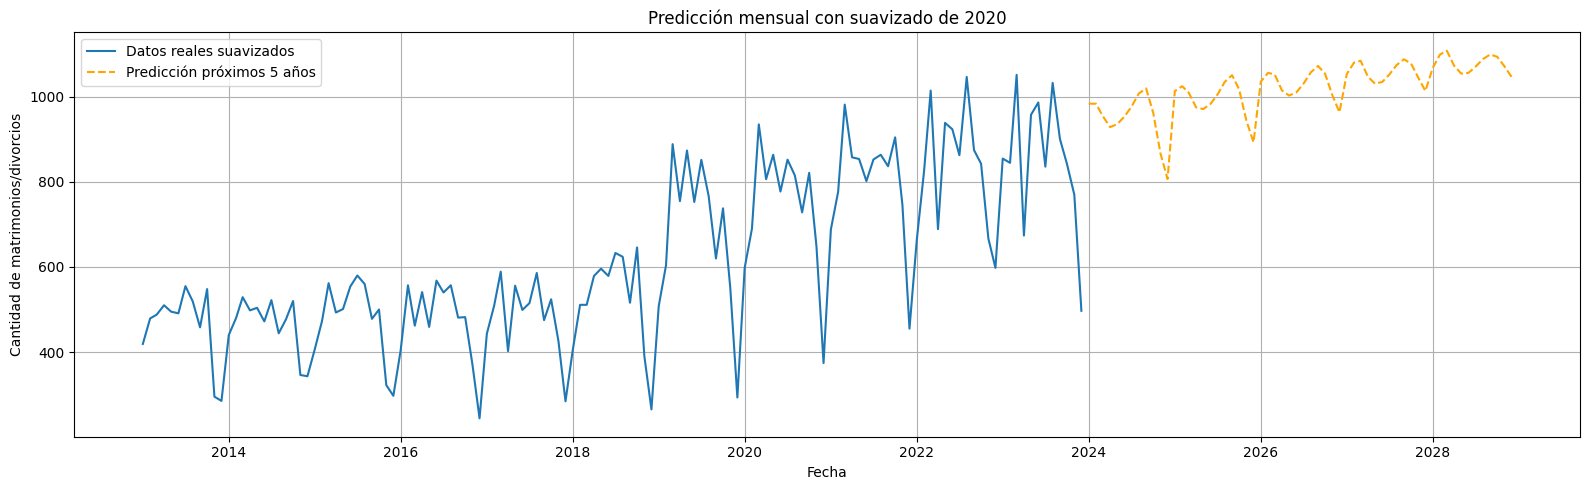

In [26]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Segundo Modelo

In [27]:

merged_df['fecha'] = pd.to_datetime(dict(year=merged_df['AÑOOCU'], month=merged_df['MESOCU'], day=1))
mensual = merged_df.groupby('fecha').size().sort_index()

mensual_suavizado = mensual.copy()

for mes in range(1, 13):
    fecha_2019 = pd.Timestamp(year=2019, month=mes, day=1)
    fecha_2020 = pd.Timestamp(year=2020, month=mes, day=1)
    fecha_2021 = pd.Timestamp(year=2021, month=mes, day=1)

    if fecha_2019 in mensual and fecha_2021 in mensual:
        promedio = (mensual[fecha_2019] + mensual[fecha_2021]) / 2
        mensual_suavizado[fecha_2020] = promedio

X_suavizado = pd.DataFrame({
    "mes": mensual_suavizado.index.month,
    "año": mensual_suavizado.index.year,
    "mes_en_numero": np.arange(len(mensual_suavizado)),
    "mes_sin": np.sin(2 * np.pi * mensual_suavizado.index.month / 12),
    "mes_cos": np.cos(2 * np.pi * mensual_suavizado.index.month / 12)
})

y_suavizado = mensual_suavizado.values


In [28]:
X_train, X_test = X_suavizado[:-12], X_suavizado[-12:]
y_train, y_test = y_suavizado[:-12], y_suavizado[-12:]

In [29]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
         (8, 6),    
        (10, 6),   
        (6, 4),     
        (12, 8),    
        (8, 6, 4),  
        (10, 8, 6), 
        (5,),      
        (12,),     
    ], 
                                             
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             MLPRegressor(early_stopping=True,
                                                                                          max_iter=2000,
                                                                                          random_state=42))]),
                                                  transformer=StandardScaler()),
             param_grid={'regressor__model__activation': ['tanh', 'logistic'],
                         'regressor__model__hidden_layer_sizes': [(8, 6),
                                                                  (10, 6),
                                                                  (6, 4),
                                                                  (12, 8),
                                                                  (8, 6, 4),
                                                                  (10, 8, 6),
                                                                  (5,), (12,)],
                         'regressor__model__learning_rate_init': (0.01, 0.1, 1),
                         'regressor__model__solver': ['adam', 'lbfgs']},
             scoring='r2')

In [ ]:
# print("R²:", r2_score(y_test, grid_search.predict(X_test)))
print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))


R²: 0.48900971519922387
MAE: 83.22065633271346
RMSE: 11472.313854935115


Los resultados del modelo muestran un error absoluto medio de aproximadamente 83.22, lo que indica que, en promedio, el modelo se equivoca por 83 unidades al realizar sus predicciones. Esta cifra representa una mejora respecto a evaluaciones anteriores, lo que sugiere una mayor precisión en las estimaciones. Por otro lado, la raíz del error cuadrático medio fue de 11,472.31, lo cual señala que, aunque el modelo ha reducido los errores más grandes en comparación con versiones anteriores, aún existen algunas predicciones con desviaciones significativas respecto a los valores reales. En conjunto, estas métricas evidencian que el modelo ha logrado un desempeño más consistente.

In [31]:
last_date = mensual_suavizado.index[-1]

n_months = 60

future_dates = [last_date + DateOffset(months=i) for i in range(1, n_months + 1)]

# Crear DataFrame con variables explicativas
X_future = pd.DataFrame({
    "mes": [date.month for date in future_dates],
    "año": [date.year for date in future_dates],
    "mes_en_numero": np.arange(len(mensual_suavizado), len(mensual_suavizado) + n_months)
})

# Codificación cíclica
X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)

# Reordenar columnas según las que usó el modelo
X_future = X_future[grid_search.feature_names_in_]

# Predecir
future_preds = grid_search.predict(X_future)

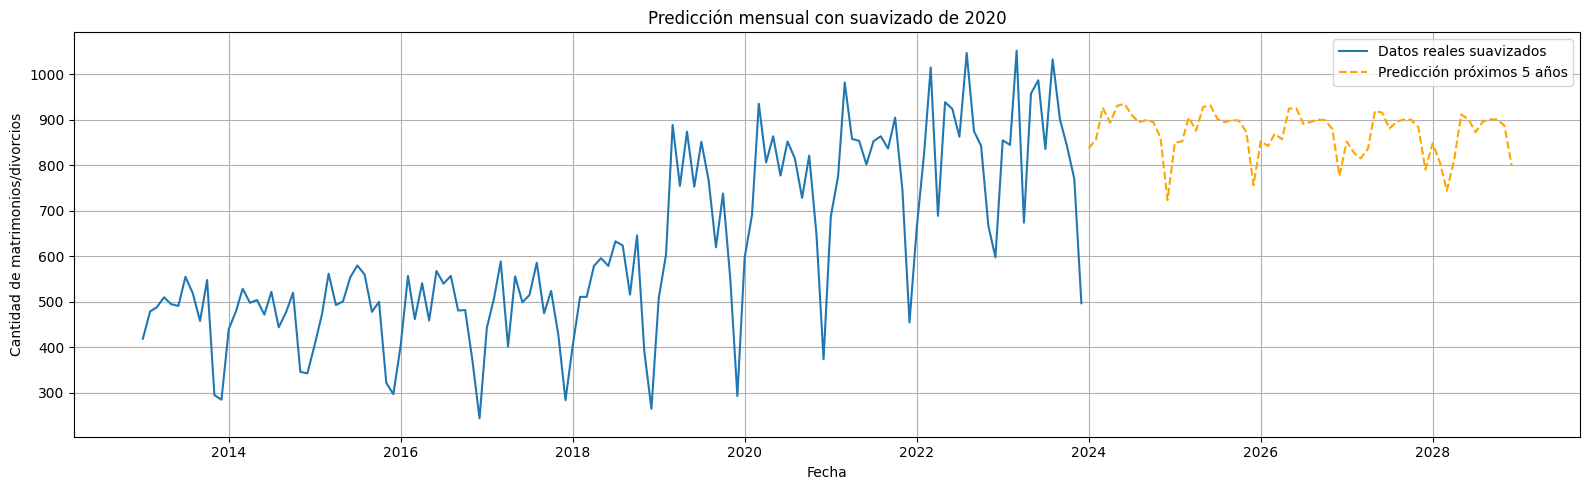

In [32]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Tercer Modelo

In [33]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (5,), (7,) ,(6,), (8,)
    ],
    "regressor__model__activation": ["relu", "tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate': ["constant", "adaptive"],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1],
}


grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             MLPRegressor(early_stopping=True,
                                                                                          max_iter=2000,
                                                                                          random_state=42))]),
                                                  transformer=StandardScaler()),
             n_jobs=-1,
             param_grid={'regressor__model__activation': ['relu', 'tanh',
                                                          'logistic'],
                         'regressor__model__hidden_layer_sizes': [(5,), (7,),
                                                                  (6,), (8,)],
                         'regressor__model__learning_rate': ['constant',
                                                             'adaptive'],
                         'regressor__model__learning_rate_init': [0.001, 0.01,
                                                                  0.05, 0.1],
                         'regressor__model__solver': ['adam', 'lbfgs']},
             scoring='r2')

In [34]:

print("R²:", r2_score(y_test, grid_search.predict(X_test)))
print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))


R²: 0.493753090994257
MAE: 92.08719837306948
RMSE: 11365.819666158632


Los resultados obtenidos muestran un error absoluto medio de 92.09, lo que indica que el modelo presenta un error promedio de aproximadamente 92 unidades por predicción. Además, la raíz del error cuadrático medio fue de 11,365.82, lo que sugiere que, aunque existen algunas predicciones con errores más grandes, estos han disminuido ligeramente en comparación con evaluaciones anteriores. La combinación de un MAE relativamente bajo y una RMSE contenida refleja que el modelo mantiene una precisión aceptable.

In [35]:
last_date = mensual_suavizado.index[-1]

future_dates = [last_date + DateOffset(months=i) for i in range(1, 61)]

último_lag = mensual_suavizado[-12]  
último_rolling = mensual_suavizado[-12:].mean() 

X_future = pd.DataFrame({
    "mes": [d.month for d in future_dates],
    "año": [d.year for d in future_dates],
    "mes_en_numero": range(len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado), 
                           len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado) + 60),
})

X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)
X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["trimestre"] = ((X_future["mes"] - 1) // 3) + 1

X_future["lag_12"] = último_lag
X_future["rolling_12"] = último_rolling

X_future = X_future[grid_search.feature_names_in_]


future_preds = grid_search.predict(X_future)


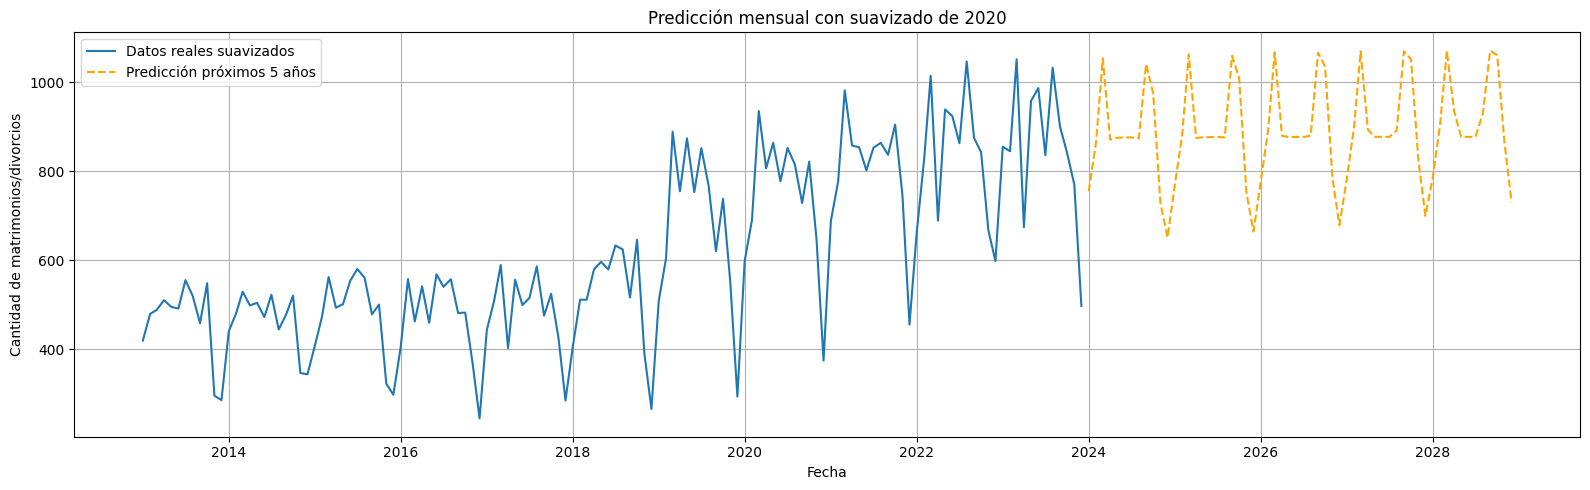

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Cuarto Modelo

In [37]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
    (5, 3), (5, 4), (6, 5), (7, 4), (8, 6)
    ],
    "regressor__model__activation": ["relu", "tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate': ["constant", "adaptive"],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1],
}


grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             MLPRegressor(early_stopping=True,
                                                                                          max_iter=2000,
                                                                                          random_state=42))]),
                                                  transformer=StandardScaler()),
             n_jobs=-1,
             param_grid={'regressor__model__activation': ['relu', 'tanh',
                                                          'logistic'],
                         'regressor__model__hidden_layer_sizes': [(5, 3),
                                                                  (5, 4),
                                                                  (6, 5),
                                                                  (7, 4),
                                                                  (8, 6)],
                         'regressor__model__learning_rate': ['constant',
                                                             'adaptive'],
                         'regressor__model__learning_rate_init': [0.001, 0.01,
                                                                  0.05, 0.1],
                         'regressor__model__solver': ['adam', 'lbfgs']},
             scoring='r2')

In [38]:
print("R²:", r2_score(y_test, grid_search.predict(X_test)))
print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))

R²: 0.45146618262100846
MAE: 86.20946423664641
RMSE: 12315.208919228155


Los resultados obtenidos muestran un error absoluto medio de 86.21, lo que indica que, en promedio, el modelo comete errores de alrededor de 86 unidades en sus predicciones. La raíz del error cuadrático medio fue de 12,315.21, lo que sugiere la presencia de errores más pronunciados en ciertos casos específicos, ya que esta métrica penaliza con mayor peso las desviaciones grandes. Aunque el modelo logra mantener un error promedio relativamente bajo, la magnitud del RMSE indica que aún existen predicciones con variaciones importantes respecto a los valores reales. Estos resultados reflejan un rendimiento aceptable.

In [39]:
last_date = mensual_suavizado.index[-1]

future_dates = [last_date + DateOffset(months=i) for i in range(1, 61)]

último_lag = mensual_suavizado[-12] 
último_rolling = mensual_suavizado[-12:].mean()  

X_future = pd.DataFrame({
    "mes": [d.month for d in future_dates],
    "año": [d.year for d in future_dates],
    "mes_en_numero": range(len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado), 
                           len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado) + 60),
})

X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)
X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["trimestre"] = ((X_future["mes"] - 1) // 3) + 1


X_future["lag_12"] = último_lag
X_future["rolling_12"] = último_rolling

X_future = X_future[grid_search.feature_names_in_]


future_preds = grid_search.predict(X_future)


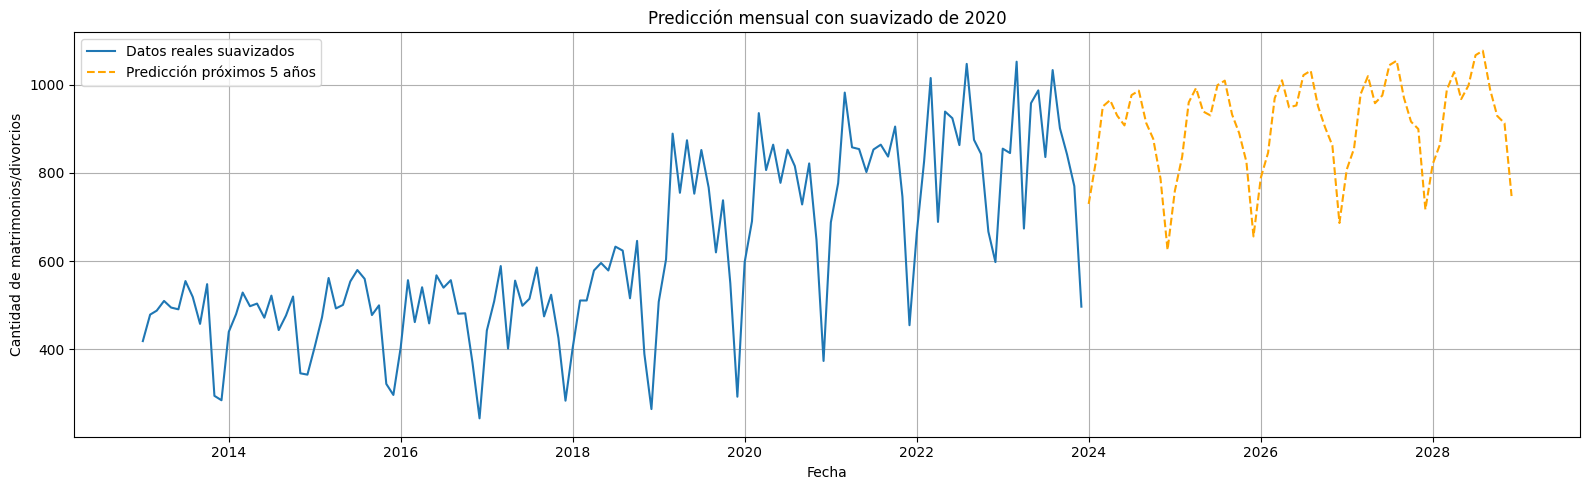

In [40]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Resultados
Al comparar los distintos modelos evaluados, se observa que el modelo 2 obtuvo el MAE más bajo (83.22), lo que indica que, en promedio, fue el más preciso en sus predicciones. Sin embargo, el modelo 3 presentó el RMSE más bajo (11,365.82), lo cual sugiere que logró reducir con mayor eficacia los errores más extremos. Aunque el modelo 2 tiene un mejor rendimiento promedio, la menor dispersión del error en el modelo 3 lo hace más consistente y robusto frente a valores atípicos. Por lo tanto, considerando el equilibrio entre precisión y estabilidad, el modelo 3 puede considerarse el de mejor desempeño general.